In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import os

import tensorflow as tf
from tensorflow import keras
from keras.utils import image_dataset_from_directory
from keras import Sequential, Input
from keras.layers import RandomFlip, RandomContrast, RandomRotation, RandomZoom, Rescaling
from keras.layers import GlobalAveragePooling2D, Dense, Conv2D, BatchNormalization, Dropout, Flatten
from keras.applications import EfficientNetV2L as base
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy as scc
from keras.callbacks import EarlyStopping, LearningRateScheduler

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

f'Tensorflow version: {tf.__version__}'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


'Tensorflow version: 2.12.0'

In [2]:
strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

DEVICES AVAILABLE: 2


In [3]:
image_size = 256
batch_size = 32
epochs = 100
lr_init = .003

train_ds = tf.keras.utils.image_dataset_from_directory(
  '/kaggle/input/medical-scan-classification-dataset/Kidney Cancer',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size)


val_ds = tf.keras.utils.image_dataset_from_directory(
  '/kaggle/input/medical-scan-classification-dataset/Kidney Cancer',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size)

Found 10000 files belonging to 2 classes.
Using 8000 files for training.
Found 10000 files belonging to 2 classes.
Using 2000 files for validation.


In [4]:
class_names = train_ds.class_names
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)
class_names

['Normal', 'Tumor']

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [6]:
es = EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.001, restore_best_weights=True)

def create_model(base_model):
    input = Input(shape=(image_size, image_size, 3))
    x = RandomFlip('horizontal')(input)
    x = RandomRotation(0.2)(x)
    x = RandomZoom(0.2,0.2)(x)
    x = RandomContrast(0.2)(x)
    b_model = base_model(x)
    flatten = Flatten()(b_model)
    x = Dense(1024,activation='relu')(flatten)
    norm = BatchNormalization()(x)
    x = Dense(512,activation='swish')(flatten)
    norm = BatchNormalization()(x)
    x = Dense(128,activation='relu')(norm)
    norm = BatchNormalization()(x)
    dropout = Dropout(0.2)(norm)
    x = Dense(len(class_names))(dropout)
    model = tf.keras.models.Model(inputs=input, outputs=x)
    
    model.compile(optimizer=Adam(lr_init),
              loss=scc(from_logits=True),
              metrics=['accuracy'])
    return model

def schedule(epoch,lr):
    if epoch < 5:
        return ((epoch)+1)*lr_init/5
    if epoch < 15:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
lr_scheduler = LearningRateScheduler(schedule,verbose=1)

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [7]:
with strategy.scope():
    base_model = base(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet')
    base_model.trainable = False
    model = create_model(base_model)

473176280/473176280 [==============================] - 2s 0us/step


In [8]:
history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                   callbacks=[es,lr_scheduler])


Epoch 1: LearningRateScheduler setting learning rate to 0.0006000000000000001.
Epoch 1/100


2023-10-04 12:45:48.308262: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetv2-l/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


250/250 [==============================] - 185s 471ms/step - loss: 0.3675 - accuracy: 0.8500 - val_loss: 0.1290 - val_accuracy: 0.9464 - lr: 6.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0012000000000000001.
Epoch 2/100
250/250 [==============================] - 101s 404ms/step - loss: 0.2448 - accuracy: 0.9032 - val_loss: 0.1654 - val_accuracy: 0.9385 - lr: 0.0012

Epoch 3: LearningRateScheduler setting learning rate to 0.0018000000000000002.
Epoch 3/100
250/250 [==============================] - 102s 406ms/step - loss: 0.2055 - accuracy: 0.9195 - val_loss: 0.1302 - val_accuracy: 0.9603 - lr: 0.0018

Epoch 4: LearningRateScheduler setting learning rate to 0.0024000000000000002.
Epoch 4/100
250/250 [==============================] - 102s 405ms/step - loss: 0.1770 - accuracy: 0.9330 - val_loss: 0.0751 - val_accuracy: 0.9712 - lr: 0.0024

Epoch 5: LearningRateScheduler setting learning rate to 0.003.
Epoch 5/100
250/250 [==============================] - 101s 402m

In [9]:
model.save('kidney_cancer.h5')

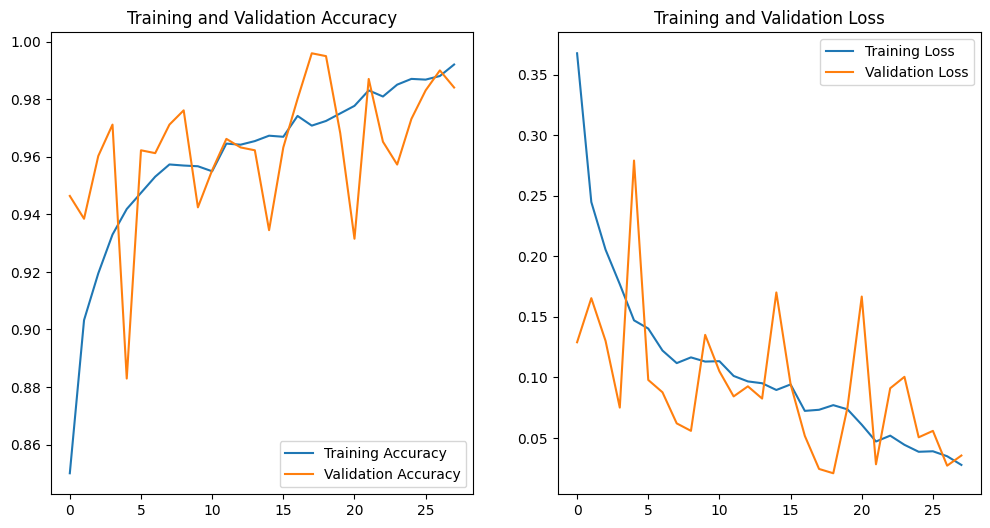

In [13]:
plot_history(history)

In [10]:
model.evaluate(test_ds)

31/31 [==============================] - 12s 351ms/step - loss: 0.0184 - accuracy: 0.9940


[0.018423661589622498, 0.9939516186714172]

In [11]:
model.evaluate(val_ds)

32/32 [==============================] - 13s 337ms/step - loss: 0.0248 - accuracy: 0.9960


[0.024821875616908073, 0.9960317611694336]